# Logistic Regression in TensorFlow

## Import Packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.0.0-beta1'

## Loading Data & Preprocessing

In [3]:
%%bigquery flights_df --verbose
SELECT date,
       airline,
       departure_airport,
       arrival_airport,
       departure_lat,
       departure_lon,
       arrival_lat,
       arrival_lon,
       departure_delay,
       arrival_delay,
       CASE WHEN (arrival_delay >= 15) THEN 1 ELSE 0 END AS delayed
    
FROM `bigquery-samples.airline_ontime_data.flights`
Where departure_airport = 'SFO' 
      AND date >= '2009-01-01' 
      AND date <= '2009-12-31'
      AND departure_delay <= 120
      AND departure_delay >= 1

Executing query with job ID: bf0ac3cc-863d-433f-8230-19af6ae6a650
Query executing: 1.05s
Query complete after 1.73s


In [4]:
flights_df.shape

(47785, 11)

In [5]:
flights_df.head()

,date,airline,departure_airport,arrival_airport,departure_lat,departure_lon,arrival_lat,arrival_lon,departure_delay,arrival_delay,delayed
0,2009-03-12,B6,SFO,AUS,37.61,-122.37,30.19,-97.67,13.0,7.0,0
1,2009-03-10,B6,SFO,AUS,37.61,-122.37,30.19,-97.67,5.0,16.0,1
2,2009-04-05,B6,SFO,AUS,37.61,-122.37,30.19,-97.67,29.0,12.0,0
3,2009-03-07,B6,SFO,AUS,37.61,-122.37,30.19,-97.67,84.0,75.0,1
4,2009-03-25,B6,SFO,AUS,37.61,-122.37,30.19,-97.67,24.0,11.0,0


In [6]:
flights_processed_df = (flights_df
                        .filter(['departure_delay', 'delayed'])
                       )

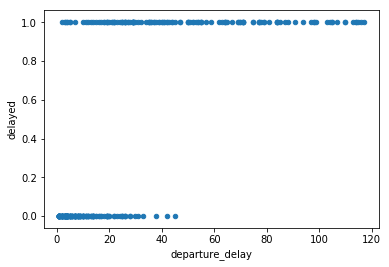

In [7]:
(flights_processed_df
 .sample(n=300, random_state = 123)
 .plot.scatter('departure_delay', 'delayed'))

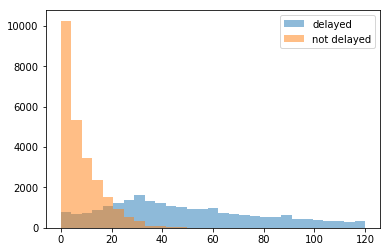

In [8]:
bins = np.linspace(0, 120, 30)
plt.hist(flights_processed_df.query('delayed == 1')['departure_delay'], bins, alpha=0.5, label='delayed')
plt.hist(flights_processed_df.query('delayed == 0')['departure_delay'], bins, alpha=0.5, label='not delayed')
plt.legend(loc='upper right')
plt.show()

Let's try to model this using logistic regression.

## Logistic Regression

### Training-Testing-Split

Split the data into training and testing set. Separate features from labels. Ignore missing values for now.

In [9]:
train_df = flights_processed_df.sample(frac=0.8,random_state=123)
test_df = flights_processed_df.drop(train_df.index)

train_labels = train_df.pop('delayed')
test_labels = test_df.pop('delayed')

### Building the Model

In [15]:
# Initialize a Sequential model using TF.Keras API:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # Adds a densely-connected layer with 1 unit to the model:
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape = [len(train_df.keys())])
    
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
             )

![](logistic_node_n.png)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


The model has two free parameters which still are the weights and bias of the regression function.

### Training the model

In [16]:
history = model.fit(train_df, train_labels, 
                    epochs=5,
                    callbacks=[tf.keras.callbacks.TensorBoard("logs/logistic-regression")])

Train on 38228 samples
Epoch 1/5
38228/38228 [==============================] - 3s 79us/sample - loss: 1.7135 - accuracy: 0.5599
Epoch 2/5
38228/38228 [==============================] - 3s 73us/sample - loss: 0.4235 - accuracy: 0.8420
Epoch 3/5
38228/38228 [==============================] - 3s 85us/sample - loss: 0.3561 - accuracy: 0.8689
Epoch 4/5
38228/38228 [==============================] - 3s 75us/sample - loss: 0.3283 - accuracy: 0.8706
Epoch 5/5
38228/38228 [==============================] - 3s 79us/sample - loss: 0.3176 - accuracy: 0.8714


### Performance evaluation of logistic regression on test data

In [17]:
test_predictions = model.predict(test_df).flatten()

test_predictions[:10]

array([0.27715677, 0.61256444, 0.12036839, 0.4219806 , 0.99983346,
       0.13468507, 0.8514509 , 0.13468507, 0.27715677, 0.9980805 ],
      dtype=float32)

Let's turn these outputs into class predictions by assuming a decision threshold of 0.5:

In [18]:
predicted_labels = (test_predictions > 0.5).astype(int)

predicted_labels[:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [19]:
results_df = pd.DataFrame({'Predicted': predicted_labels, 'Actual': test_labels})
results_df.head(10)

,Actual,Predicted
0,0,0
4,0,1
13,0,0
17,1,0
22,1,1
35,0,0
36,1,1
37,0,0
41,0,0
47,1,1
